# Simple MNIST Convolutional Classifier
A simple classiefier for later us, specifically for visualization.

In [25]:
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.activations as activations
from tensorflow.python.keras.models import Model
import os
import scipy
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
import itertools

## Helper Functions

From https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html. Plot a confusion matrix nicely.

In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## The Dataset
Loading the MNIST Dataset.

In [2]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

There are 60,000 images of numbers with values ranging from 0 to 255.

Shape: (60000, 28, 28)
Min. Value: 0
Max. Value: 255


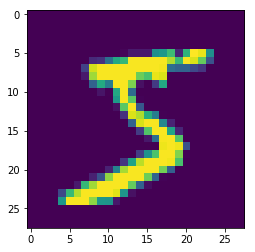

In [3]:
print("Shape: {}".format(x_train.shape))
print("Min. Value: {}".format(np.min(x_train)))
print("Max. Value: {}".format(np.max(x_train)))
plt.imshow(x_train[0])

Normalizing the dataset to values betweeen -0.5 and 0.5.

Shape: (60000, 28, 28)
Min. Value: -0.5
Max. Value: 0.5


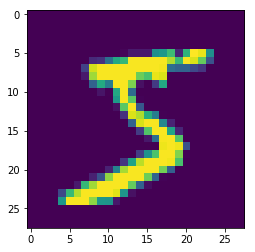

In [4]:
x_train = (x_train - 127.5) / 255
x_test = (x_test - 127.5) / 255

print("Shape: {}".format(x_train.shape))
print("Min. Value: {}".format(np.min(x_train)))
print("Max. Value: {}".format(np.max(x_train)))
plt.imshow(x_train[0])

The label data is not in the right format and has to be converted to one-hot vectors.

In [5]:
print(y_train.shape)
for i in range(10):
    print(y_train[i])

(60000,)
5
0
4
1
9
2
1
3
1
4


In [6]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print(y_train.shape)
for i in range(10):
    print(y_train[i])

(60000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


## The Model
Defining some constants for later.

In [7]:
LEARNING_RATE = 0.001
BATCH_SIZE = 100
EPOCHS = 10

Defining the model architecture.

In [8]:
input_layer = layers.Input(shape=(28,28))

# This reshaping has to be done, to add the channel dimension, which is used and extended by the convolutional layers
# It would also be possible to reshape the dataset beforehand
x = layers.Reshape(target_shape=(28,28,1))(input_layer)

# Padding "same" is needed or the ouput would not be of size 28 by 28, but smaller
# because the size of the input is not divisible by the kernal size
x = layers.Conv2D(filters=8, kernel_size=3, padding="same", activation="relu")(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x) # Shape down to (14,14,8)
x = layers.Conv2D(filters=16, kernel_size=3, padding="same", activation="relu")(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x) # Shape down to (7,7,16)
x = layers.Flatten()(x) # Shape down to (784,)
x = layers.Dense(128, activation="relu")(x)
classifier_output = layers.Dense(10, activation="softmax", name="classifier_output")(x)

classifier = Model(input_layer, classifier_output)

classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
__________

Defining the optimizers and loss functions. Using the Adam optimizer and cross entropy loss.

In [9]:
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
loss = keras.losses.categorical_crossentropy

# Compiling the model, keeping track of the accuracy
classifier.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

## Training

In [10]:
history = classifier.fit(x=x_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         validation_data=(x_test, y_test),
                         epochs=EPOCHS,
                         shuffle=True,
                         verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 7s - loss: 0.3121 - acc: 0.9129 - val_loss: 0.0995 - val_acc: 0.9682
Epoch 2/10
 - 4s - loss: 0.0787 - acc: 0.9757 - val_loss: 0.0552 - val_acc: 0.9823
Epoch 3/10
 - 4s - loss: 0.0553 - acc: 0.9828 - val_loss: 0.0462 - val_acc: 0.9847
Epoch 4/10
 - 4s - loss: 0.0438 - acc: 0.9860 - val_loss: 0.0439 - val_acc: 0.9856
Epoch 5/10
 - 4s - loss: 0.0358 - acc: 0.9890 - val_loss: 0.0384 - val_acc: 0.9873
Epoch 6/10
 - 4s - loss: 0.0296 - acc: 0.9908 - val_loss: 0.0355 - val_acc: 0.9887
Epoch 7/10
 - 4s - loss: 0.0258 - acc: 0.9915 - val_loss: 0.0326 - val_acc: 0.9891
Epoch 8/10
 - 4s - loss: 0.0224 - acc: 0.9927 - val_loss: 0.0321 - val_acc: 0.9885
Epoch 9/10
 - 4s - loss: 0.0182 - acc: 0.9940 - val_loss: 0.0321 - val_acc: 0.9895
Epoch 10/10
 - 4s - loss: 0.0152 - acc: 0.9949 - val_loss: 0.0303 - val_acc: 0.9909


## Visualizing the Results

In [11]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

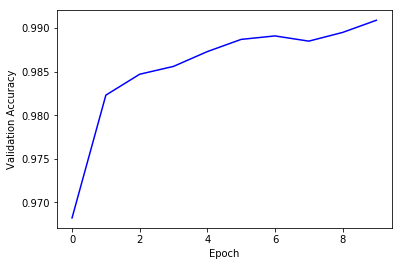

In [12]:
plt.figure()
plt.plot(history.history["val_acc"], color="blue")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.show()

Using the model on the test data.

In [17]:
test_results = classifier.predict(x_test)

Converting the output from "one-hot"-style vector to class.

In [19]:
print("Style befor conversion: {}\n".format(test_results[0]))
test_results = np.argmax(test_results, axis=1)
print("Style after conversion: {}\n".format(test_results[0]))
print("True label: {}".format(np.argmax(y_test[0])))

Style befor conversion: [1.1935119e-12 6.5811212e-10 1.5900795e-09 1.6279246e-08 2.0886327e-10
 2.2214854e-10 7.1950653e-16 9.9999964e-01 2.2655735e-09 3.2400399e-07]

Style after conversion: 7

True label: 7


Calculating and printing the normalized confusion matrix.

Normalized confusion matrix
[[9.96e-01 0.00e+00 0.00e+00 1.02e-03 0.00e+00 0.00e+00 3.06e-03 0.00e+00
  0.00e+00 0.00e+00]
 [0.00e+00 9.99e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 8.81e-04 0.00e+00
  0.00e+00 0.00e+00]
 [1.94e-03 9.69e-04 9.87e-01 9.69e-04 1.94e-03 0.00e+00 9.69e-04 3.88e-03
  1.94e-03 0.00e+00]
 [0.00e+00 0.00e+00 9.90e-04 9.95e-01 0.00e+00 3.96e-03 0.00e+00 0.00e+00
  0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 9.95e-01 0.00e+00 1.02e-03 0.00e+00
  0.00e+00 4.07e-03]
 [2.24e-03 1.12e-03 0.00e+00 5.61e-03 0.00e+00 9.89e-01 2.24e-03 0.00e+00
  0.00e+00 0.00e+00]
 [3.13e-03 4.18e-03 0.00e+00 1.04e-03 1.04e-03 2.09e-03 9.89e-01 0.00e+00
  0.00e+00 0.00e+00]
 [0.00e+00 3.89e-03 0.00e+00 1.95e-03 0.00e+00 0.00e+00 0.00e+00 9.89e-01
  9.73e-04 3.89e-03]
 [2.05e-03 0.00e+00 1.03e-03 2.05e-03 1.03e-03 2.05e-03 4.11e-03 1.03e-03
  9.84e-01 3.08e-03]
 [0.00e+00 0.00e+00 0.00e+00 9.91e-04 6.94e-03 3.96e-03 0.00e+00 1.98e-03
  9.91e-04 9.85e-01]]


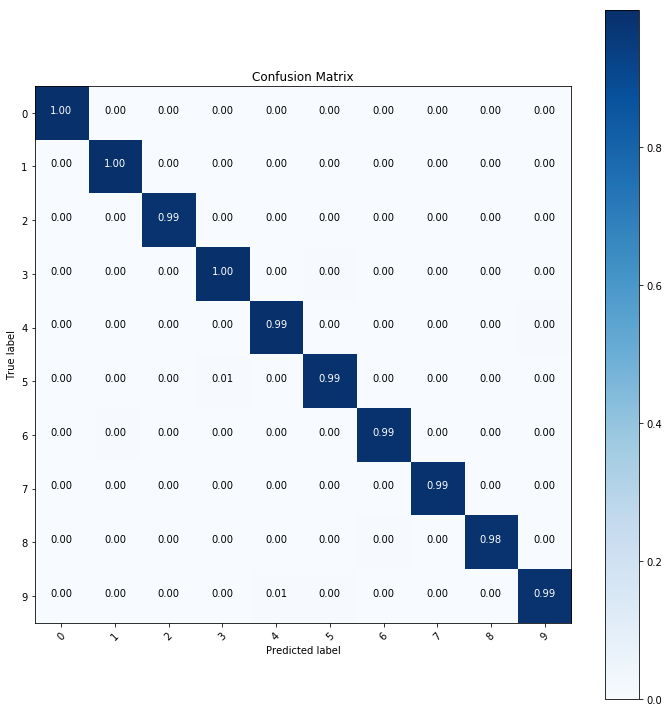

In [34]:
plt.figure(figsize=(10,10))
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), test_results)
plot_confusion_matrix(cnf_matrix, classes=range(10), title="Confusion Matrix", normalize=True)

## Saving the Model

In [13]:
classifier.save("mnist_conv_class.h5")